# Laboratório 6
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: AutoEncoders
No laboratório de hoje, veremos uma técnica diferente de Aprendizado de Máquina, os AutoCodificadores, ou AutoEncoders (AE). Os AEs são considerados como um método de aprendizado auto-supervisionado (ou _self supervised learning_), em que o próprio modelo define as "classes", para funcionar de modo semelhante ao aprendizado supervisionado. O AE funciona de modo que a entrada e saída esperada do modelo são iguais, ou seja, o modelo vai apenas aprender como copiar a entrada para a saída! Dessa forma, não precisamos rotular os dados, mas temos o objetivo de cada entrada bem definido! Os Grandes Modelos de Linguagem (LLMs) também se encaixam nesse método de aprendizado, sendo treinados com as palavras anteriores tentando prever a próxima palavra dentro de um mesmo texto.

Mas... isso não seria apenas copiar a entrada para a saída? Só fazendo os neurônios replicarem a entrada sem a alterarem? Sim, _seria_. A diferença é que os AEs possuem uma estrutura própria, dividida em duas partes:
- Codificador (*Encoder*): Conjunto de camadas que recebe os dados de entrada e processá-os, os "codificando" para um vetor de tamanho menor do que a entrada, chamado de Vetor Latente (*Feature Vector*), que é gerado como saída do Codificador.
- Decodificador (*Decoder*): Conjunto de camadas que recebe o Vetor Latente como entrada e o transforma na saída esperada.

## Exemplo 1.1: AutoEncoders com scikit-learn
Vamos ver um exemplo da aplicação de um AE no scikit-learn. Podemos fazer isso utilizando um `MLPRegressor`, definindo o tamanho das camadas no formado codificador-decodificador. O modelo de regressão é mais apropriado pois queremos minimizar o erro, ou diferença, entre a entrada e a saída.

Como exemplo, utilizremos imagens de gatos e cachorros da base de dados `cats_and_dogs`, integrada ao Keras.

### Instalando a base

In [1]:
#Instalando a base de dados. Usada apenas para o exemplo, não é necessário para o restante do notebook.

import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=False)
extract_path = os.path.splitext(path_to_zip)[0]

# Extract only once
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Paths to the small filtered dataset
train_dir = os.path.join(extract_path, "cats_and_dogs_filtered/train")
validation_dir = os.path.join(extract_path, "cats_and_dogs_filtered/validation")

# Load a small subset for quick use
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True,
    seed=42
)

# Normalize images
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))


2025-10-10 16:27:04.959088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-10 16:27:09.718269: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Found 2000 files belonging to 2 classes.


2025-10-10 16:27:12.898875: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Entendendo a base
Após instalar a base, podemos olhar alguns exemplos dela. São todas imagens de 64x64 pixels, classificadas como gatos e cachorros.

2025-10-10 16:27:13.217316: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


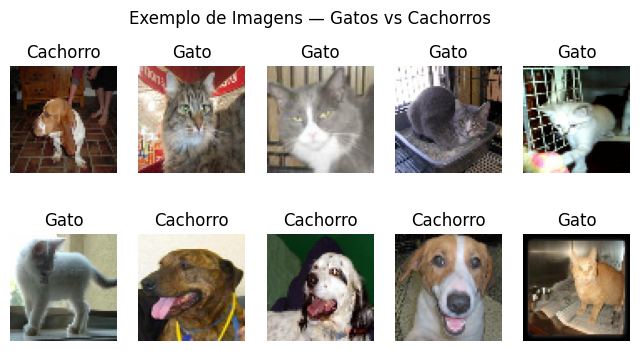

In [2]:
plt.figure(figsize=(8, 4))
for images, labels in train_ds.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title("Gato" if labels[i].numpy() == 0 else "Cachorro")
        plt.axis("off")
plt.suptitle("Exemplo de Imagens — Gatos vs Cachorros")
plt.show()


Vamos observar um exemplo mais de perto para entender como esses dados funcionam. Cada imagem é uma matriz de 64x64x3, em que as duas primeiras dimensões são o tamanho da imagem, e a última diz respeito aos valores RGB (vermelho, verde e azul) de cada pixel, com valores de 0 a 255, formando a cor. Dessa forma, cada elemento da base é um array de 12288 valores!

Shape: (64, 64, 3), Label: Cachorro


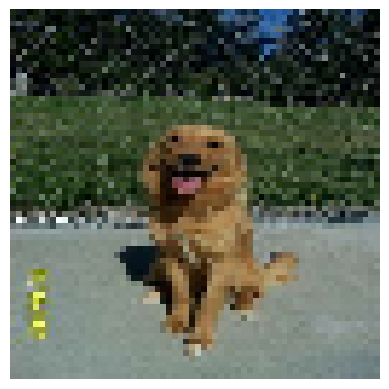

In [3]:
# Exemplo de imagem em array
for images, labels in train_ds.take(1):
    example_image = images[0].numpy()
    example_label = labels[0].numpy()
    print(f"Shape: {example_image.shape}, Label: {'Gato' if example_label == 0 else 'Cachorro'}")
    plt.imshow(example_image)
    plt.axis("off")
    plt.show()
    break

### Aplicando AutoEncoder
Esse valor é importante para sabermos o tamanho da entrada e saída do AE. Vamos ver agora um exemplo de como aplicar o AE nessa base.

In [ ]:
# Exemplo de AutoEncoder com scikit-learn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Preparando os dados
X = []
for images, labels in train_ds:
    for img in images:
        X.append(img.numpy().flatten())
X = np.array(X)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
print(f"Tamanho do dataset: {X.shape}, Tamanho do treino: {X_train.shape}, Tamanho do teste: {X_test.shape}")

# Definindo o AutoEncoder
input_size = X.shape[1]  # 64*64*3 = 12288
hidden_size = 128  # Tamanho do espaço latente
ae = MLPRegressor(hidden_layer_sizes=(hidden_size, input_size), max_iter=200, random_state=42)

# Treinando o AutoEncoder
ae.fit(X_train, X_train)

# Avaliando o AutoEncoder
X_test_pred = ae.predict(X_test)
mse = mean_squared_error(X_test, X_test_pred)
print(f"Mean Squared Error no conjunto de teste: {mse}")

2025-10-10 16:27:14.962333: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Tamanho do dataset: (2000, 12288), Tamanho do treino: (1600, 12288), Tamanho do teste: (400, 12288)
